In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community as cm

### Lendo dataset Harry Potter

In [26]:
atri = pd.read_csv('../data/harrypotter/hpattributes.txt', sep='\t')
ares = pd.read_csv('../data/harrypotter/hpbook2.txt', sep=' ', header=None)
nome = pd.read_csv('../data/harrypotter/hpnames.txt', sep='\t')

In [27]:
gpotter = nx.DiGraph()

# config nodes

n = atri.shape[0]

for k in range(n):
    gpotter.add_node(k,
                     nome = nome['name'][k],
                     ano = atri['schoolyear'][k],
                     gen = atri['gender'][k],
                     casa = atri['house'][k])
    
# create network
for k in range(n):
    for m in range(n):
        if ares.values[k][m] == 1:
            gpotter.add_edge(k,m)

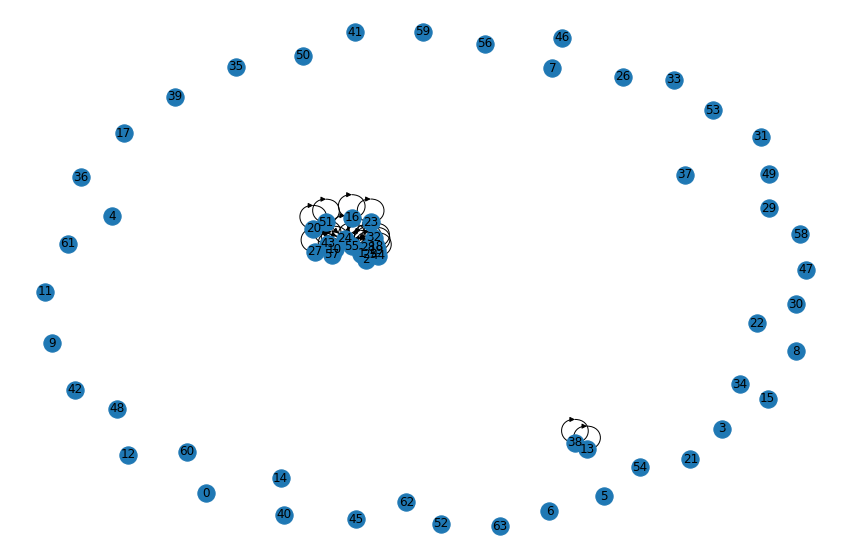

In [28]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(gpotter,with_labels=True)
plt.show()

In [29]:
# matriz de adjacência esparsa
A = nx.adjacency_matrix(gpotter)

# apagamos os nós isolados: 
# eles fazem parte de uma comunidade e, possívelmente, não foram personagens desse livro
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nós isolados.')

44 nós isolados.


In [30]:
# matriz de adjacência esparsa
A = nx.adjacency_matrix(gpotter)

# matriz de adjacência densa
A = np.array(A.todense(),dtype=float)

In [31]:
# algoritmo CONCOR

C = A.copy()

while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
    C = np.corrcoef(C)

C = np.round(C)

In [32]:
# algoritmo CONCOR

com1 = []
com2 = []
nos  = list(gpotter.nodes)
com1.append(nos[0])
for k in range(1,len(nos)):
    if C[0,k] > 0:
        com1.append(nos[k])
    else:
        com2.append(nos[k])

print('Comunidade 1:')
for k in range(len(com1)):
    print(gpotter.nodes[com1[k]]['nome'])

Comunidade 1:
Alicia Spinnet
Angelina Johnson
Fred Weasley
George Weasley
Hermione Granger
Katie Bell
Lee Jordan
Oliver Wood
Ronald Weasley


In [33]:
print('Comunidade 2:')
for k in range(len(com2)):
    print(gpotter.nodes[com2[k]]['nome'])

Comunidade 2:
Dean Thomas
Draco Malfoy
Ernie Macmillan
Ginny Weasley
Hannah Abbott
Harry James Potter
Justin Finch-Fletchley
Marcus Flint
Neville Longbottom
Percy Weasley
Seamus Finnigan


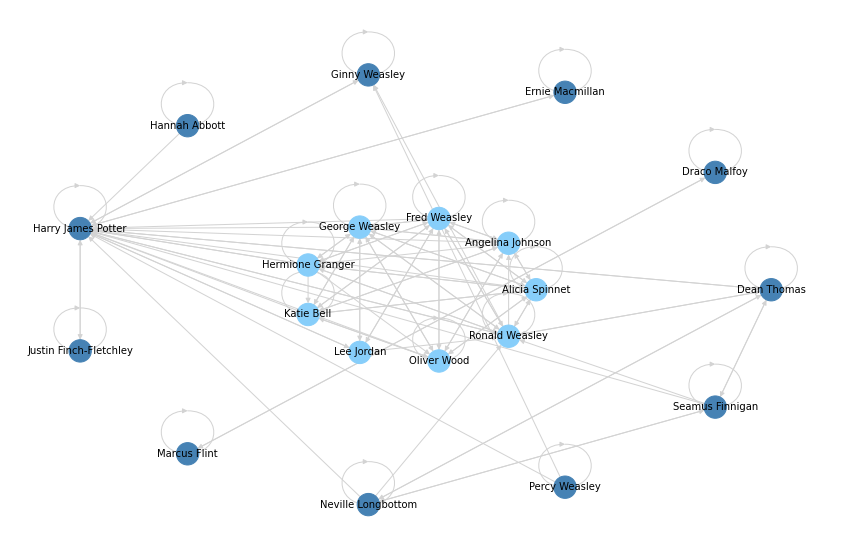

In [34]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 100*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 100*np.sin(2*np.pi*k/len(com1))

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)

plt.box(False)
#plt.xlim((-400,+400))
plt.show()

## Modularidade

### Louvain Community Detection Algorithm

Find the best partition of a graph using the Louvain Community Detection Algorithm.

Louvain Community Detection Algorithm is a simple method to extract the community structure of a network. 
This is a heuristic method based on modularity optimization.

The algorithm works in 2 steps. 
On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. 
If no positive gain is achieved the node remains in its original community.

The modularity gain obtained by moving an isolated node $i$ into a community $C$ can easily be calculated by the following formula:
where $m$ is the size of the graph, 
$k_{i,in}$ is the sum of the weights of the links from $i$ to nodes in $C$, 
$k_i$ is the sum of the weights of the links incident to node $i$, 
$\Sigma_{tot}$ is the sum of the weights of the links incident to nodes in $C$ and 
$\gamma$ is the resolution parameter.

For the directed case the modularity gain can be computed using this formula according to [3]_
where $k_i^{out}$, 
$k_i^{in}$ are the outer and inner weighted degrees of node $i$ and 
$\Sigma_{tot}^{in}$, $\Sigma_{tot}^{out}$ are the sum of in-going and out-going links incident to nodes in $C$.

The first phase continues until no individual move can improve the modularity.

The second phase consists in building a new network whose nodes are now the communities found in the first phase. 
To do so, the weights of the links between the new nodes are given by the sum of the weight of the links between nodes in the corresponding two communities. 
Once this phase is complete it is possible to reapply the first phase creating bigger communities with increased modularity.

The above two phases are executed until no modularity gain is achieved (or is less than the threshold).

Be careful with self-loops in the input graph. 
These are treated as previously reduced communities -- as if the process had been started in the middle of the algorithm. 
Large self-loop edge weights thus represent strong communities and in practice may be hard to add other nodes to. 
If your input graph edge weights for self-loops do not represent already reduced communities you may want to remove the self-loops before inputting that graph.

**Parameters**

G : NetworkX graph

weight : string or None, optional (default="weight")
    The name of an edge attribute that holds the numerical value used as a weight. If None then each edge has weight 1.

resolution : float, optional (default=1)
    If resolution is less than 1, the algorithm favors larger communities. Greater than 1 favors smaller communities

threshold : float, optional (default=0.0000001)
    Modularity gain threshold for each level. 
    If the gain of modularity between 2 levels of the algorithm is less than the given threshold then the algorithm stops and returns the resulting communities.

seed : integer, random_state, or None (default)
    Indicator of random number generation state.

**Returns**

list
    A list of sets (partition of G). Each set represents one community and contains all the nodes that constitute it.

Notes
The order in which the nodes are considered can affect the final output. 
In the algorithm the ordering happens using a random shuffle.

In [36]:
# Examples

G = nx.petersen_graph()

nx.community.louvain_communities(G, seed=123)

[{0, 4, 5, 7, 9}, {1, 2, 3, 6, 8}]

### greedy modularity maximization

Find communities in G using greedy modularity maximization.

This function uses Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity.

Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible (a maximum). 
Two keyword arguments adjust the stopping condition. 
cutoff is a lower limit on the number of communities so you can stop the process before reaching a maximum (used to save computation time). 
best_n is an upper limit on the number of communities so you can make the process continue until at most n communities remain even if the maximum modularity occurs for more. 
To obtain exactly n communities, set both cutoff and best_n to n.

This function maximizes the generalized modularity, where resolution is the resolution parameter, often expressed as $\gamma$.
See ~networkx.algorithms.community.quality.modularity.

**Parameters**

G : NetworkX graph

weight : string or None, optional (default=None)
    The name of an edge attribute that holds the numerical value used as a weight. If None, then each edge has weight 1. The degree is the sum of the edge weights adjacent to the node.

resolution : float, optional (default=1)
    If resolution is less than 1, modularity favors larger communities. Greater than 1 favors smaller communities.

cutoff : int, optional (default=1)
    A minimum number of communities below which the merging process stops. The process stops at this number of communities even if modularity is not maximized. The goal is to let the user stop the process early. The process stops before the cutoff if it finds a maximum of modularity.

best_n : int or None, optional (default=None)
    A maximum number of communities above which the merging process will not stop. This forces community merging to continue after modularity starts to decrease until best_n communities remain. If None, don't force it to continue beyond a maximum.

**Raises**

ValueError : If the cutoff or best_n value is not in the range
    [1, G.number_of_nodes()], or if best_n < cutoff.

**Returns**

communities: list
    A list of frozensets of nodes, one for each community. Sorted by length with largest communities first.

In [38]:
# Examples

G = nx.karate_club_graph()

c = nx.community.greedy_modularity_communities(G)
for it in c:
    print(sorted(it))

[8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 7, 9, 12, 13, 17, 21]
[0, 4, 5, 6, 10, 11, 16, 19]


In [39]:
comsl = cm.louvain_communities(gpotter)
comsc = cm.greedy_modularity_communities(gpotter,cutoff=len(comsl))

print('Modularidade - Louvain: {:.3f}'.format(cm.modularity(gpotter,comsl)))
print('Modularidade - CNM    : {:.3f}'.format(cm.modularity(gpotter,comsc)))

Modularidade - Louvain: 0.371
Modularidade - CNM    : 0.371


In [40]:
plt.close('all')

#fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

coresp = {0:'lightskyblue',
          1:'steelblue',
          2:'gray',
          3:'pink',
          4:'magenta',
          5:'violet',
          6: 'mediumorchid'}

coresl = []
for no in gpotter.nodes():
    for k in range(len(comsl)):
        if no in comsl[k]:
            coresl.append(coresp[k])
            break

coresc = []
for no in gpotter.nodes():
    for k in range(len(comsc)):
        if no in comsc[k]:
            coresc.append(coresp[k])
            break
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

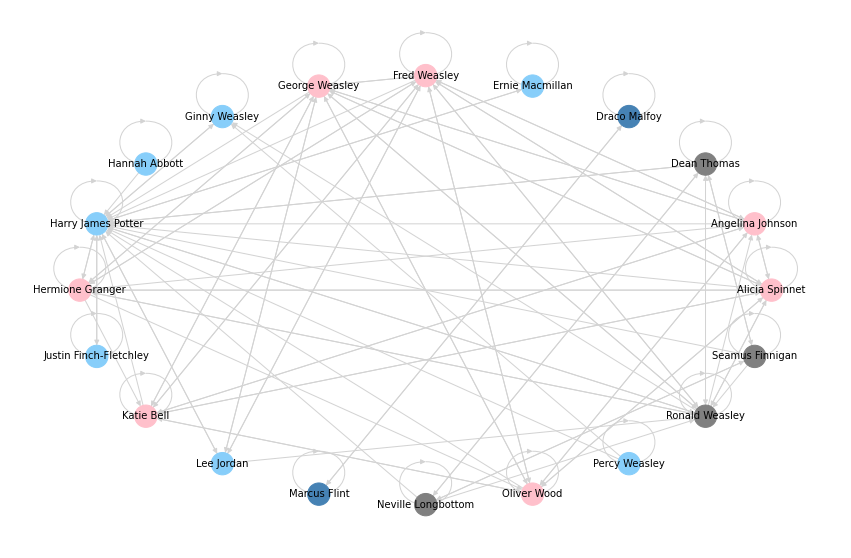

In [41]:
#plt.figure()

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500,
                 labels=etiquetas,
                 font_size=10, 
                 node_color=coresl)

plt.box(False)
plt.show()

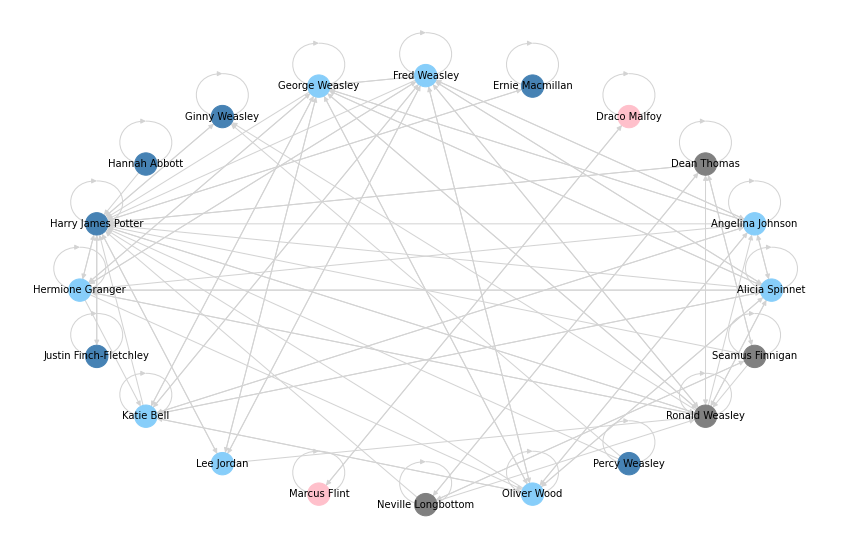

In [42]:
#plt.figure()

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500,
                 labels=etiquetas,
                 font_size=10, 
                 node_color=coresc)

plt.box(False)

plt.show()

### community

Functions for computing and measuring community structure.

The community subpackage can be accessed by using networkx.community, then accessing the functions as attributes of community. 

In [43]:
# example 

G = nx.barbell_graph(5, 1)

communities_generator = nx.community.girvan_newman(G)

top_level_communities = next(communities_generator)

next_level_communities = next(communities_generator)

print(sorted(map(sorted, top_level_communities)))
print(sorted(map(sorted, next_level_communities)))

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10]]
[[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]


In [44]:
mper = +np.inf
for ini in gpotter.nodes:
    com1 = set([ini])
    com2 = set(nos) - com1
    
    mgan = -1
    while mgan < 0:
        cv,pe = cm.partition_quality(gpotter,[com1,com2])
        ra = (1-cv)/(len(com1)*len(com2)) 
        mgan = +np.inf
        mno  = -1
        for no in com2:
            ncom1 = com1.union(set([no]))
            ncom2 = com2 - set([no])
            cv,pe = cm.partition_quality(gpotter,[ncom1,ncom2])
            nra   = (1-cv)/(len(ncom1)*len(ncom2))
            ng    = nra-ra
            if ng < mgan:
                mgan = ng
                mno  = no
        if mgan < 0:
            com1.add(mno)
            com2.remove(mno)
    cv,pe = cm.partition_quality(gpotter,[com1,com2])            
    ra = (1-cv)/(len(com1)*len(com2)) 
    if ra < mper:
        mper = ra
        mcom1 = com1.copy()
        mcom2 = com2.copy()

In [45]:
com1 = list(mcom1)
com2 = list(mcom2)

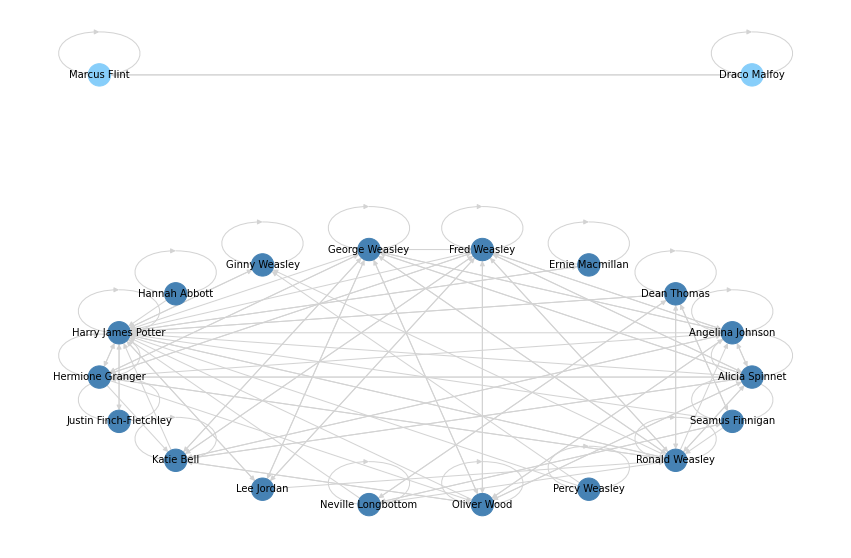

In [46]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

#plt.figure()
nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()

In [47]:
com1, com2 = cm.kernighan_lin_bisection(gpotter.to_undirected(), max_iter =100)

In [48]:
com1 = list(com1)
com2 = list(com2)

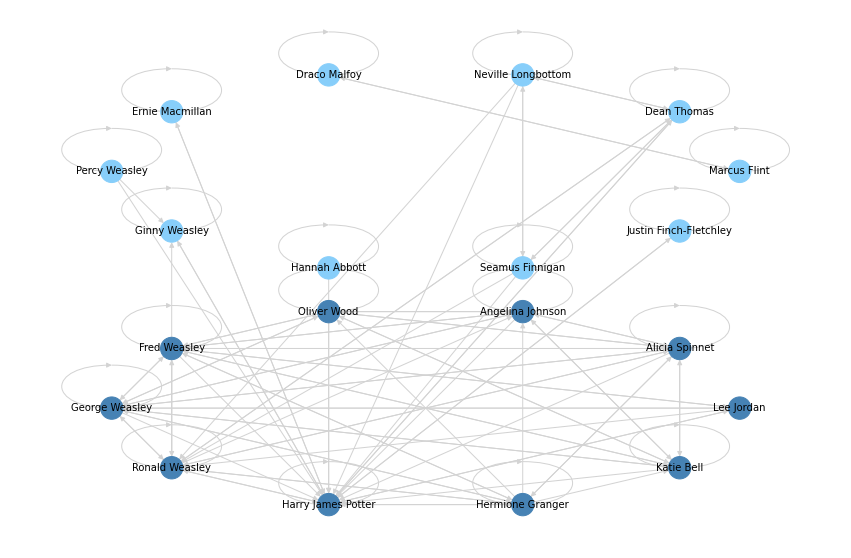

In [49]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

#plt.figure()
nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()

### Modularidade espectral

### CONCOR

In [50]:
# matrix de adjacencia
A = nx.adjacency_matrix(gpotter)

In [51]:
# apagando os nos isolados 
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nós isolados.')

IndexError: index (20) out of range

In [ ]:
# matriz de adjacencia esparsa
A = nx.adjacency_matrix(gpotter)

In [ ]:
# matriz de adjacencia densa
A = np.array(A.todense(),dtype=float)

In [ ]:
# algoritmo CONCOR

C = A.copy()

while not np.allclose(np.abs(C),np.ones_like(C),atol=1e-10):
    C = np.corrcoef(C)

C = np.round(C)

In [ ]:
com1 = []
com2 = []

nos  = list(gpotter.nodes)

com1.append(nos[0])

for k in range(1,len(nos)):
    if C[0,k] > 0:
        com1.append(nos[k])
    else:
        com2.append(nos[k])

In [ ]:
print('Comunidade 1:')
for k in range(len(com1)):
    print(gpotter.nodes[com1[k]]['nome'])

In [ ]:
print('Comunidade 2:')
for k in range(len(com2)):
    print(gpotter.nodes[com2[k]]['nome'])

In [ ]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 100*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 100*np.sin(2*np.pi*k/len(com1))

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500, 
                 labels=etiquetas,
                 font_size=10, 
                 node_color=cores)

plt.box(False)
#plt.xlim((-400,+400))
plt.show()

### Remoção de arestas

Finds communities in a graph using the Girvan–Newman method.

**Parameters**

G : NetworkX graph

most_valuable_edge : function
    Function that takes a graph as input and outputs an edge. The edge returned by this function will be recomputed and removed at each iteration of the algorithm.

    If not specified, the edge with the highest
    networkx.edge_betweenness_centrality will be used.

**Returns**

iterator
    Iterator over tuples of sets of nodes in G. Each set of node is a community, each tuple is a sequence of communities at a particular level of the algorithm.



In [56]:
# Examples
# To get the first pair of communities:
G = nx.path_graph(10)
comp = nx.community.girvan_newman(G)
tuple(sorted(c) for c in next(comp))

([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

In [58]:
# To get only the first *k* tuples of communities, use itertools.islice:
import itertools

G = nx.path_graph(8)

k = 2
comp = nx.community.girvan_newman(G)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))
#    ...
#    ([0, 1, 2, 3], [4, 5, 6, 7])
#    ([0, 1], [2, 3], [4, 5, 6, 7])

([0, 1, 2, 3], [4, 5, 6, 7])
([0, 1], [2, 3], [4, 5, 6, 7])


In [59]:
# To stop getting tuples of communities once the number of communities is greater than *k*, use itertools.takewhile:
import itertools

G = nx.path_graph(8)

k = 4
comp = nx.community.girvan_newman(G)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    print(tuple(sorted(c) for c in communities))
#    ...
#    ([0, 1, 2, 3], [4, 5, 6, 7])
#    ([0, 1], [2, 3], [4, 5, 6, 7])
#    ([0, 1], [2, 3], [4, 5], [6, 7])

([0, 1, 2, 3], [4, 5, 6, 7])
([0, 1], [2, 3], [4, 5, 6, 7])
([0, 1], [2, 3], [4, 5], [6, 7])


In [61]:
# To just choose an edge to remove based on the weight:
from operator import itemgetter

G = nx.path_graph(10)

edges = G.edges()
nx.set_edge_attributes(G, {(u, v): v for u, v in edges}, "weight")

def heaviest(G):
    u, v, w = max(G.edges(data="weight"), key=itemgetter(2))
    return (u, v)

comp = nx.community.girvan_newman(G, most_valuable_edge=heaviest)

tuple(sorted(c) for c in next(comp))

([0, 1, 2, 3, 4, 5, 6, 7, 8], [9])

In [62]:
# To utilize edge weights when choosing an edge with, for example, the highest betweenness centrality:

from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)
    ...
G = nx.path_graph(10)

comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)

tuple(sorted(c) for c in next(comp))
#    ([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

In [65]:
# To specify a different ranking algorithm for edges, use the most_valuable_edge keyword argument:

from networkx import edge_betweenness_centrality
from random import random

def most_central_edge(G):
    centrality = edge_betweenness_centrality(G)
    max_cent = max(centrality.values())
    
    # Scale the centrality values so they are between 0 and 1,
    # and add some random noise.
    centrality = {e: c / max_cent for e, c in centrality.items()}
    
    # Add some random noise.
    centrality = {e: c + random() for e, c in centrality.items()}
    
    return max(centrality, key=centrality.get)

G = nx.path_graph(10)

comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)

for it in comp:
    print(it)

({0, 1, 2, 3, 4, 5}, {8, 9, 6, 7})
({0, 1}, {2, 3, 4, 5}, {8, 9, 6, 7})
({0, 1}, {2, 3}, {4, 5}, {8, 9, 6, 7})
({0, 1}, {2, 3}, {4, 5}, {8, 6, 7}, {9})
({0, 1}, {2, 3}, {4, 5}, {6, 7}, {8}, {9})
({0, 1}, {2, 3}, {4}, {5}, {6, 7}, {8}, {9})
({0, 1}, {2}, {3}, {4}, {5}, {6, 7}, {8}, {9})
({0}, {1}, {2}, {3}, {4}, {5}, {6, 7}, {8}, {9})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9})


**Notes**

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. 

The algorithm removes the "most valuable" edge, traditionally the edge with the highest betweenness centrality, at each step. 

As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [52]:
com = cm.girvan_newman(gpotter)
com = list(com)

In [53]:
for it in gpotter.nodes():
    print(it, ':', gpotter.nodes[it]['nome'])

1 : Alicia Spinnet
2 : Angelina Johnson
10 : Dean Thomas
13 : Draco Malfoy
16 : Ernie Macmillan
18 : Fred Weasley
19 : George Weasley
20 : Ginny Weasley
23 : Hannah Abbott
24 : Harry James Potter
25 : Hermione Granger
27 : Justin Finch-Fletchley
28 : Katie Bell
32 : Lee Jordan
38 : Marcus Flint
43 : Neville Longbottom
44 : Oliver Wood
51 : Percy Weasley
55 : Ronald Weasley
57 : Seamus Finnigan


In [54]:
for it in com:
    print(it)

({32, 1, 2, 10, 43, 44, 18, 19, 20, 23, 51, 55, 24, 25, 27, 28, 57}, {13, 38}, {16})
({32, 1, 2, 10, 43, 44, 18, 19, 20, 51, 55, 24, 25, 27, 28, 57}, {13, 38}, {16}, {23})
({32, 1, 2, 10, 43, 44, 18, 19, 20, 51, 55, 24, 25, 28, 57}, {13, 38}, {16}, {23}, {27})
({32, 1, 2, 10, 43, 44, 18, 19, 55, 24, 25, 28, 57}, {13, 38}, {16}, {51, 20}, {23}, {27})
({32, 1, 2, 44, 18, 19, 55, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27})
({1, 2, 44, 18, 19, 55, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32})
({1, 2, 44, 18, 19, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2, 44, 18, 19, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2}, {57, 10, 43}, {13, 38}, {16}, {44, 18, 19, 24, 25, 28}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2}, {10}, {13, 38}, {16}, {44, 18, 19, 24, 25, 28}, {51, 20}, {23}, {27}, {32}, {57, 43}, {55})
({1}, {2}, {10}, {13}, {16}, {44, 18, 19, 24, 25, 28}, {51, 

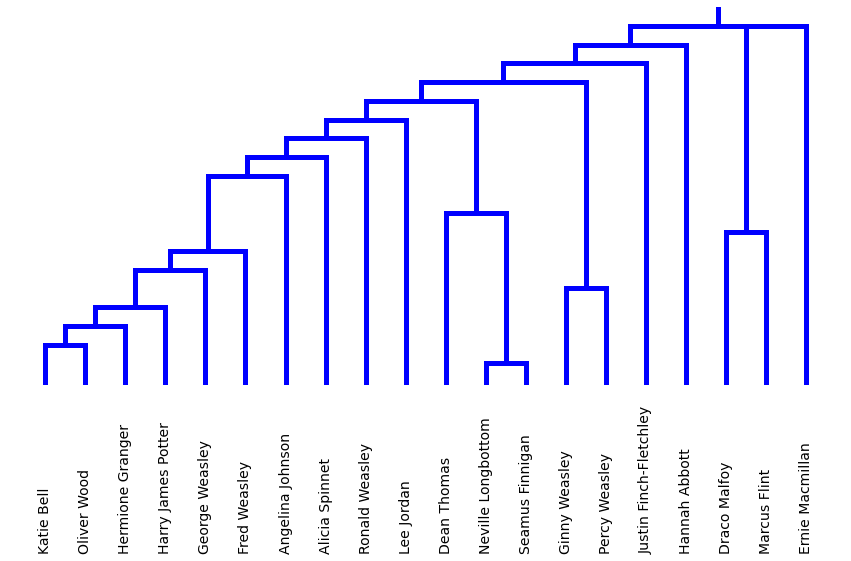

In [55]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

plt.plot([-3.90380859375,-3.90380859375],[0,-20],'b',linewidth=5)
plt.plot([0,-47.8076171875,40,40],[-20,-20,-20,-20],'b', linewidth=5)
plt.plot([40,40],[-20,-400],'b', linewidth=5)
plt.plot([-47.8076171875,-47.8076171875],[-20,-40],'b', linewidth=5)
plt.plot([-75.615234375,-20],[-40,-40],'b', linewidth=5)
plt.plot([-20,-20],[-40,-400],'b', linewidth=5)
plt.plot([-75.615234375,-75.615234375],[-40,-60],'b', linewidth=5)
plt.plot([-111.23046875,-40],[-60,-60],'b', linewidth=5)
plt.plot([-40,-40],[-60,-400],'b', linewidth=5)
plt.plot([-111.23046875,-111.23046875],[-60,-80],'b',linewidth=5)
plt.plot([-152.4609375,-70],[-80,-80],'b', linewidth=5)
# plt.plot([-80,-80],[-80,-100],'b', linewidth=5)
plt.plot([-152.4609375,-152.4609375],[-80,-100],'b', linewidth=5)
plt.plot([-179.921875,-125],[-100,-100],'b', linewidth=5)
# plt.plot([-80,-80],[-80,-100],'b', linewidth=5)
plt.plot([-179.921875,-179.921875],[-100,-120],'b', linewidth=5)
plt.plot([-125,-125],[-100,-220],'b', linewidth=5)
plt.plot([-199.84375,-160],[-120,-120],'b', linewidth=5)
plt.plot([-160,-160],[-120,-400],'b', linewidth=5)
plt.plot([-199.84375,-199.84375],[-120,-140],'b', linewidth=5)
plt.plot([-219.6875,-180],[-140,-140],'b', linewidth=5)
plt.plot([-180,-180],[-140,-400],'b', linewidth=5)
plt.plot([-219.6875,-219.6875],[-140,-160],'b', linewidth=5)
plt.plot([-239.375,-200],[-160,-160],'b', linewidth=5)
plt.plot([-200,-200],[-160,-400],'b', linewidth=5)
plt.plot([-239.375,-239.375],[-160,-180],'b', linewidth=5)
plt.plot([-258.75,-220],[-180,-180],'b', linewidth=5)
plt.plot([-220,-220],[-180,-400],'b', linewidth=5)
# plt.plot([-400,-400],[-180,-200],'b', linewidth=5)
# plt.plot([-120,-120],[-100,-220],'b', linewidth=5)
plt.plot([-140,-120],[-220,-220],'b', linewidth=5)
plt.plot([-140,-140],[-220,-400],'b', linewidth=5)
plt.plot([10,10],[-20,-240],'b', linewidth=5)
plt.plot([00,20],[-240,-240],'b', linewidth=5)
plt.plot([0,0],[-240,-400],'b', linewidth=5)
plt.plot([20,20],[-240,-400],'b', linewidth=5)
plt.plot([-258.75,-258.75],[-180,-260],'b', linewidth=5)
plt.plot([-277.5,-240],[-260,-260],'b', linewidth=5)   
plt.plot([-240,-240],[-260,-400],'b', linewidth=5)

plt.plot([-277.5,-277.5],[-260,-280],'b', linewidth=5)
plt.plot([-295,-260],[-280,-280],'b', linewidth=5)
plt.plot([-260,-260],[-280,-400],'b', linewidth=5)

plt.plot([-70,-70],[-80,-300],'b', linewidth=5)
plt.plot([-80,-60],[-300,-300],'b', linewidth=5)
plt.plot([-80,-80],[-300,-400],'b', linewidth=5)
plt.plot([-60,-60],[-300,-400],'b', linewidth=5)

plt.plot([-295,-295],[-280,-320],'b', linewidth=5)
plt.plot([-315,-280],[-320,-320],'b', linewidth=5)
plt.plot([-280,-280],[-320,-400],'b', linewidth=5)
plt.plot([-315,-315],[-320,-340],'b', linewidth=5)

plt.plot([-340,-320],[-360,-360],'b', linewidth=5)
plt.plot([-340,-340],[-360,-400],'b', linewidth=5)
plt.plot([-320,-320],[-360,-400],'b', linewidth=5)

    
plt.plot([-330,-330],[-340,-360],'b', linewidth=5)
plt.plot([-330,-300],[-340,-340],'b', linewidth=5)
plt.plot([-300,-300],[-340,-400],'b', linewidth=5)


plt.plot([-140,-110],[-220,-220],'b', linewidth=5)
plt.plot([-110,-110],[-220,-380],'b', linewidth=5)
plt.plot([-120,-100],[-380,-380],'b', linewidth=5)
plt.plot([-120,-120],[-380,-400],'b', linewidth=5)
plt.plot([-100,-100],[-380,-400],'b', linewidth=5)

plt.box(False)
plt.xticks([])
plt.yticks([])
plt.ylim(-580,0)
plt.text(-340,-580,gpotter.nodes[28]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-320,-580,gpotter.nodes[44]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-300,-580,gpotter.nodes[25]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-280,-580,gpotter.nodes[24]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-260,-580,gpotter.nodes[19]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-240,-580,gpotter.nodes[18]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-220,-580,gpotter.nodes[ 2]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-200,-580,gpotter.nodes[ 1]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-180,-580,gpotter.nodes[55]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-160,-580,gpotter.nodes[32]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-140,-580,gpotter.nodes[10]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-120,-580,gpotter.nodes[43]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-100,-580,gpotter.nodes[57]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 80,-580,gpotter.nodes[20]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(- 60,-580,gpotter.nodes[51]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 40,-580,gpotter.nodes[27]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 20,-580,gpotter.nodes[23]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-  0,-580,gpotter.nodes[13]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(+ 20,-580,gpotter.nodes[38]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(+ 40,-580,gpotter.nodes[16]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.show()

### Agrupamento hierárquico

**Hierarchical clustering (scipy.cluster.hierarchy)**

These functions cut hierarchical clusterings into flat clusterings or find the roots of the forest formed by a cut by providing the flat cluster ids of each observation.

These are routines for agglomerative clustering.

These routines compute statistics on hierarchies.

Routines for visualizing flat clusters.

These are data structures and routines for representing hierarchies as tree objects.

These are predicates for checking the validity of linkage and inconsistency matrices as well as for checking isomorphism of two flat cluster assignments.

Utility routines for plotting:

Utility classes:

In [ ]:
import scipy.cluster.hierarchy as hier

In [ ]:
A = nx.adjacency_matrix(gpotter)

A = np.array(A.todense(), dtype = float)

S = np.copy(A.T)

In [ ]:
Z = hier.linkage(S, 'complete', metric='euclidean')

In [ ]:
nomes = [gpotter.nodes[n]['nome'] for n in gpotter.nodes]

# (function) def set_link_color_palette(palette: Any) -> None

Set list of matplotlib color codes for use by dendrogram.

Note that this palette is global (i.e., setting it once changes the colors for all subsequent calls to dendrogram) and that it affects only the the colors below color_threshold.

Note that dendrogram also accepts a custom coloring function through its link_color_func keyword, which is more flexible and non-global.

Parameters

palette : list of str or None
    A list of matplotlib color codes. The order of the color codes is the order in which the colors are cycled through when color thresholding in the dendrogram.

    If None, resets the palette to its default (which are matplotlib default colors C1 to C9).

Returns
None

See Also
dendrogram

Notes
Ability to reset the palette with None added in SciPy 0.17.0.

In [67]:
# Examples
import numpy as np
from scipy.cluster import hierarchy

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,400., 754., 564., 138., 219., 869., 669.])

Z = hierarchy.linkage(ytdist, 'single')

dn = hierarchy.dendrogram(Z, no_plot=True)

dn['color_list']

#['C1', 'C0', 'C0', 'C0', 'C0']

['c', 'C0', 'C0', 'C0', 'C0']

In [ ]:
hier.set_link_color_palette(['b'])

Plot the hierarchical clustering as a dendrogram.

The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children. 

The top of the U-link indicates a cluster merge. 

The two legs of the U-link indicate which clusters were merged. 

The length of the two legs of the U-link represents the distance between the child clusters. 

It is also the cophenetic distance between original observations in the two children clusters.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))

with plt.rc_context({'lines.linewidth': 5}):
    dn = hier.dendrogram(Z, 
                         color_threshold = np.inf,
                         leaf_rotation = 'vertical', 
                         leaf_font_size = 14, 
                         labels = nomes )
    
plt.tight_layout()
plt.box(False)
#_ = plt.yticks ()
plt.show()